In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
from IPython.core.display import display, HTML
np.random.seed(42)

%matplotlib inline

In [2]:
affair_df = sm.datasets.fair.load_pandas().data

Data is taken from [here](https://www.statsmodels.org/devel/datasets/generated/fair.html)

The exercise is about repeated regression modeling, let's try to split the data by the level of education and build one model per level here.

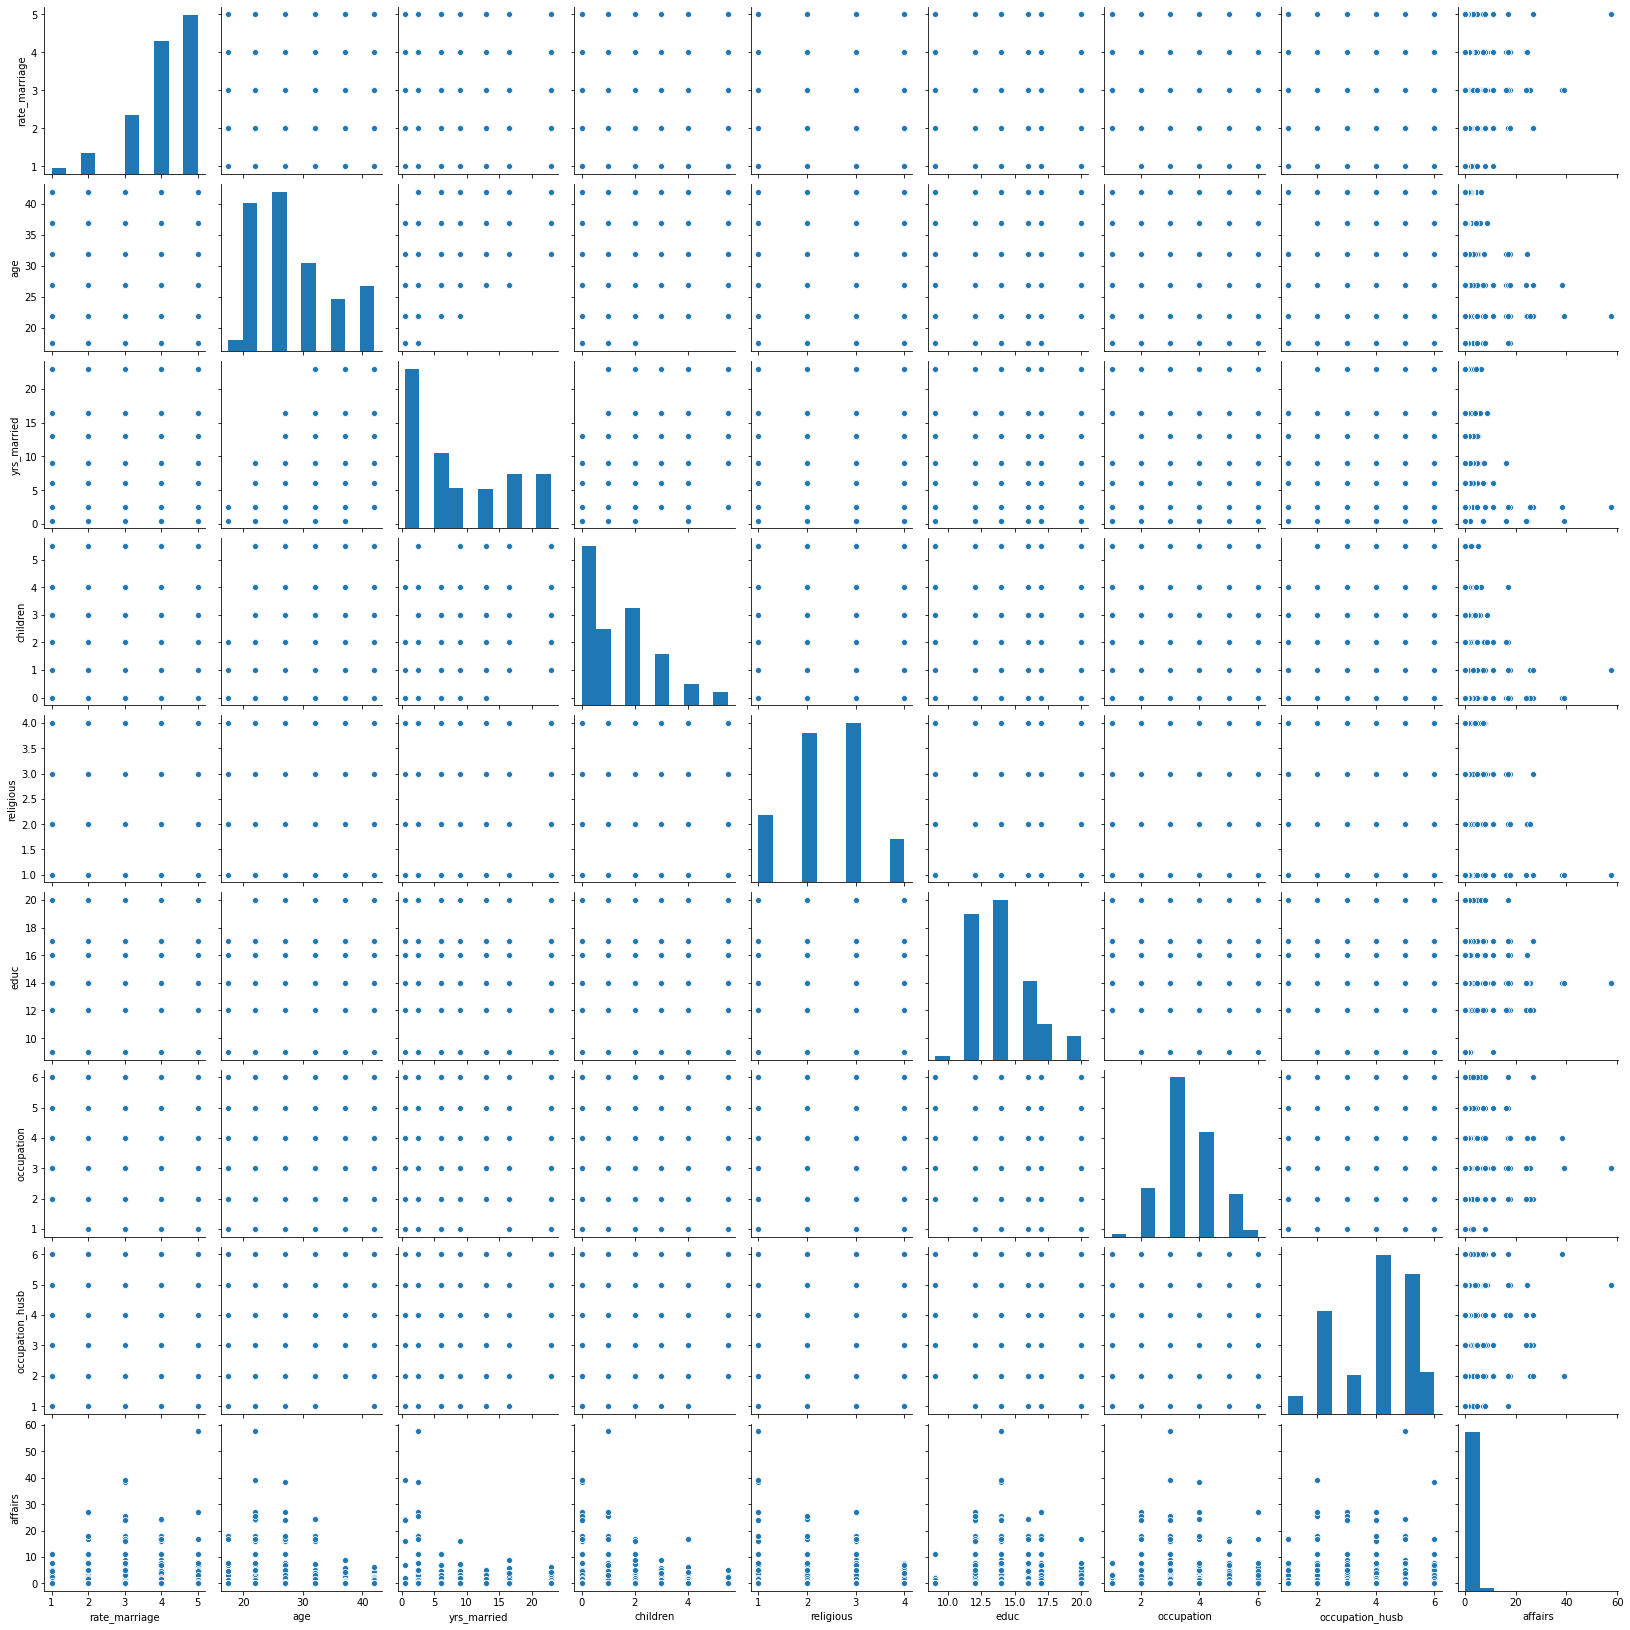

In [3]:
sns.pairplot(affair_df)

In [4]:
affair_df.assign(
    was_an_affair=lambda x: (x.affairs>0.01)
).groupby("was_an_affair").agg(cnt=("was_an_affair", "count"))

,cnt
was_an_affair,
False,4313
True,2053


We're dealing with a regression problem, where the target variable is an amount of time spend in an affair, this a huge number of zero values might be harmful for the model performance and should be aimed with a logistic model, rather than a regressive one.

In [10]:
cheaters_df = affair_df[affair_df.affairs>0.0]

assert len(cheaters_df) == 2053, "Only rows with non-zero target variable are left"

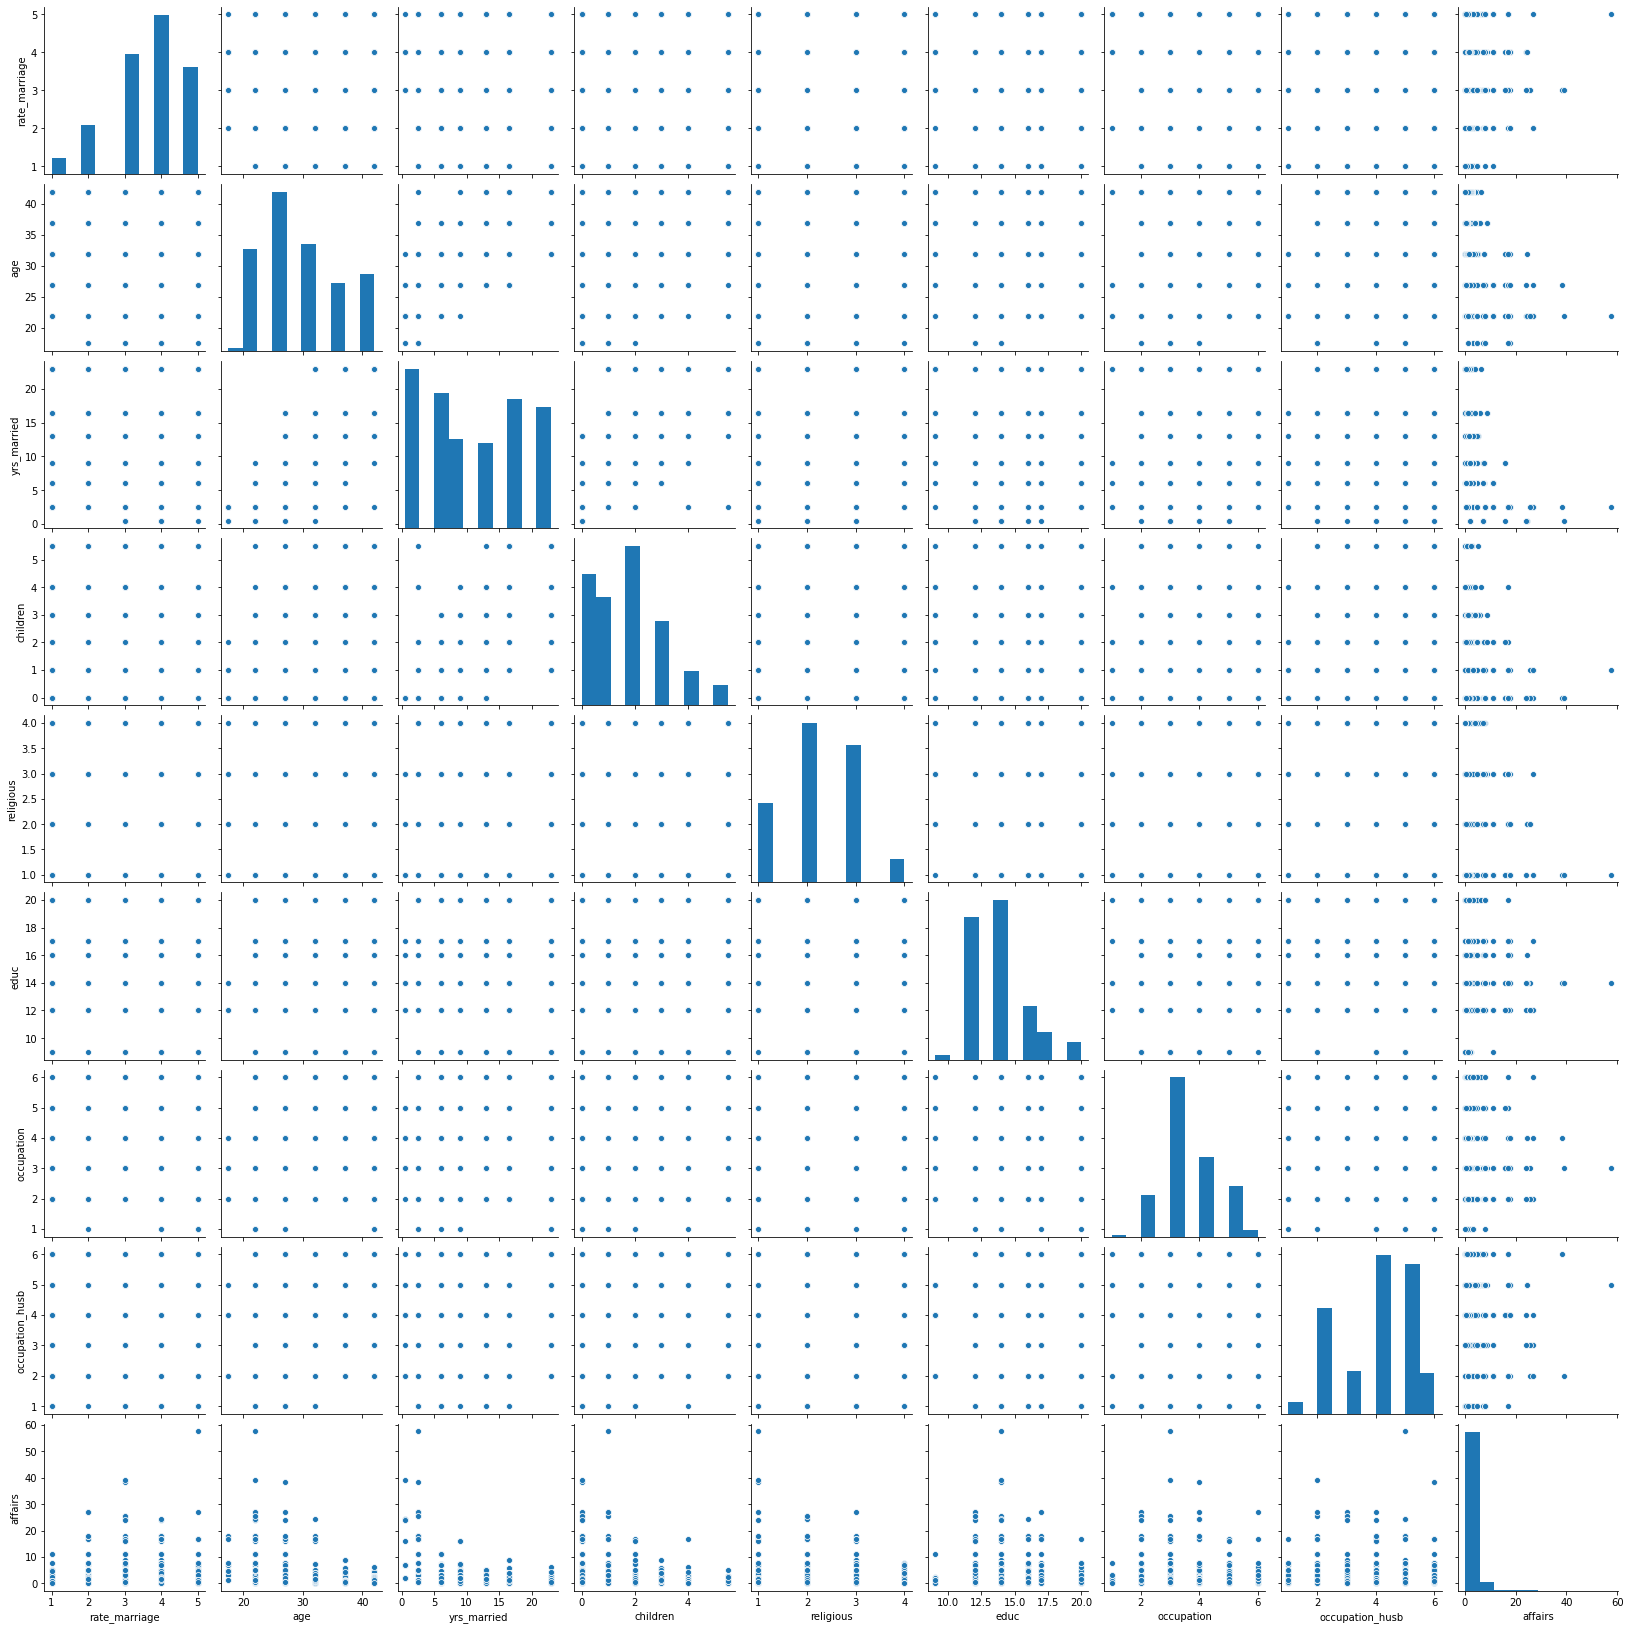

In [11]:
sns.pairplot(cheaters_df)

Let's reason about variable transformations and interactions

* We bucket the `educ` variable into four groups in order to build one model per group.
* The target variable has a long tail and a large amount of values close to zero, we can try a log transformation here.
* The age is pretty correlated with the number of years married, we can try to use a difference between those, rather than absolute values.
* `rate_marriage` is ordinal, still some normalization is better be made.
* Some magic for both occupation fields is needed, but we can work on that later


In [37]:
cheaters_to_model = cheaters_df.assign(
    ed_labels=lambda x: pd.cut(
        x.educ, 
        [0,4,10,13,20], 
        include_lowest=True, 
        right=False, 
        labels=['elementary', 'middle', 'high', 'grad']
    ),
    affairs=lambda x: np.log(x.affairs),
    age_to_yrs_married=lambda x: x.age - x.yrs_married,
    age_to_yrs_married_cntrd=lambda x: (x.age_to_yrs_married - x.age_to_yrs_married.mean())/(2*x.age_to_yrs_married.std()),
    yrs_married=lambda x: (x.yrs_married - x.yrs_married.mean())/(2*x.yrs_married.std()),
    constant=1
)

In [39]:
mdl = sm.OLS(
    exog=cheaters_to_model.drop(columns=[
        'affairs', 
        'ed_labels',
        'age',
        'age_to_yrs_married',
        'educ'
    ]), 
    endog=cheaters_df.affairs
).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                affairs   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     49.94
Date:                Tue, 10 Mar 2020   Prob (F-statistic):           7.06e-66
Time:                        15:59:38   Log-Likelihood:                -5285.5
No. Observations:                2053   AIC:                         1.059e+04
Df Residuals:                    2045   BIC:                         1.063e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
rate_marriage               -0.2133      0.066     -3.219      0.001      -0.343      -0.083
yrs_married                 -2.1491      0.209    -10.261      0.000      -2.560      -1.738
children                    -0.1301      0.072     -1.801      0.072      -0.272       0.012
religious                   -0.2963      0.085     -3.479      0.001      -0.463      -0.129
occupation                   0.0174      0.075      0.233      0.816      -0.129       0.164
occupation_husb             -0.0290      0.055     -0.528      0.598      -0.137       0.079
age_to_yrs_married_cntrd     0.1149      0.153      0.750      0.453      -0.186       0.415
constant                     3.9126      0.454      8.620      0.000       3.022       4.803
==============================================================================
Omnibus:                     2411.427   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           364733.039
Skew:                           5.922   Prob(JB):                         0.00
Kurtosis:                      67.215   Cond. No.                         47.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
mdls = {}
for ed_lbl, df in cheaters_to_model.groupby('ed_labels'):
    if len(df)>0:
        mdl = sm.OLS(
            exog=df.drop(columns=[
                'affairs', 
                'ed_labels',
                'age',
                'age_to_yrs_married',
                'educ'
            ]), 
            endog=df.affairs
        ).fit()
        mdls[ed_lbl] = mdl

In [46]:
mdls['middle'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                affairs   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     1.867
Date:                Tue, 10 Mar 2020   Prob (F-statistic):              0.157
Time:                        16:27:05   Log-Likelihood:                -26.280
No. Observations:                  21   AIC:                             68.56
Df Residuals:                      13   BIC:                             76.92
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
rate_marriage               -0.3644      0.234     -1.559      0.143      -0.869       0.141
yrs_married                  0.2402      0.895      0.268      0.793      -1.694       2.175
children                     0.0631      0.242      0.261      0.799      -0.460       0.586
religious                   -0.5131      0.357     -1.436      0.175      -1.285       0.259
occupation                  -0.2710      0.216     -1.257      0.231      -0.737       0.195
occupation_husb              0.5002      0.220      2.270      0.041       0.024       0.976
age_to_yrs_married_cntrd     0.7143      0.489      1.462      0.168      -0.341       1.770
constant                     1.0112      1.444      0.700      0.496      -2.109       4.132
==============================================================================
Omnibus:                        0.945   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.623   Jarque-Bera (JB):                0.757
Skew:                          -0.088   Prob(JB):                        0.685
Kurtosis:                       2.087   Cond. No.                         47.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
mdls_summary = pd.DataFrame()
for lbl, mdl in mdls.items():
    mdl_summary=pd.DataFrame().assign(
        coefficient=mdl.params,
        se=mdl.bse,
        ed_lvl=lbl,
        field_name=mdl.bse.index
    ).reset_index()
    mdls_summary = pd.concat([mdls_summary, mdl_summary])
    
mdls_summary = mdls_summary.reset_index().drop(columns=['level_0', 'index']).assign(
    ub=lambda x: x.coefficient + x.se,
    lb=lambda x: x.coefficient - x.se
).melt(
    id_vars=['ed_lvl', 'field_name'],
    value_vars=['coefficient', 'ub', 'lb']
)

In [69]:
mdls_summary

,ed_lvl,field_name,variable,value
0,middle,rate_marriage,coefficient,-0.364405
1,middle,yrs_married,coefficient,0.240233
2,middle,children,coefficient,0.063108
3,middle,religious,coefficient,-0.513086
4,middle,occupation,coefficient,-0.270984
...,...,...,...,...
67,grad,religious,lb,-0.128434
68,grad,occupation,lb,-0.025946
69,grad,occupation_husb,lb,-0.046826
70,grad,age_to_yrs_married_cntrd,lb,-0.146361


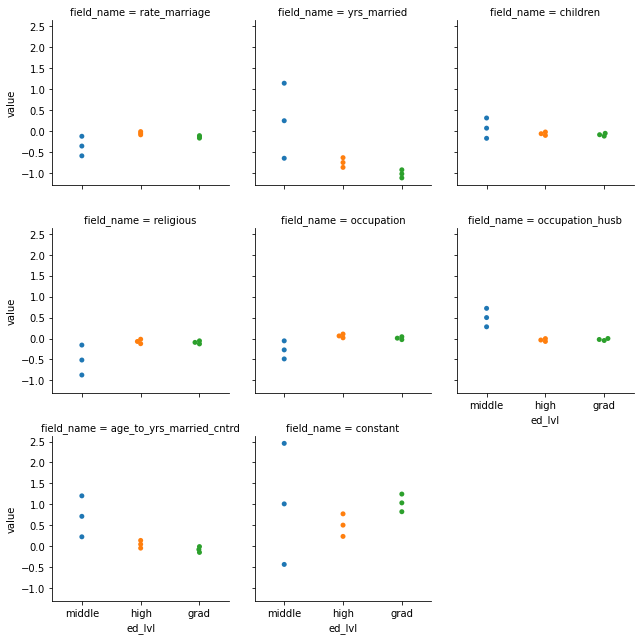

In [97]:
sns.catplot(
    data=mdls_summary,
    x='ed_lvl',
    y='value',
    col='field_name',
    col_wrap=3,
    kind='swarm',
    height=3,
    ci=None,
);

Not 